In [1]:
from __future__ import print_function

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,ReduceLROnPlateau

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
# from tensorflow.keras.datasets import mnist, cifar10
import tensorflow_addons as tfa

import sklearn
from itertools import chain

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.io import loadmat 
import mat73
from datetime import datetime
import ipynbname

from mpl_toolkits.axes_grid1 import make_axes_locatable # For confusion matrix plot
print("Packages Loaded")

Packages Loaded


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      #tf_config = tf.ConfigProto(allow_soft_placement=False)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
#tf.keras.mixed_precision.set_global_policy('mixed_float16')
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

1 Physical GPUs, 1 Logical GPUs


In [3]:
import wandb
from wandb.keras import WandbCallback
time_stamp = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
wandb.init(project="my-test-project", entity="ibksolar", name=ipynbname.name()+'_'+time_stamp, config={})

config = wandb.config 

wandb: Currently logged in as: ibksolar (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Update to smaller Batch size 24th Feb, 2022

In [4]:
# Load data
# raw_data1 = loadmat('new_echo_cnn_in_out_jstarrs2021_first_try/echo_cnn_in_out_jstars1.mat')
# raw_data1 = loadmat('echo_cnn_in_out_GOOD_layers/new_echo_cnn_in_out_jstars1.mat') 'findpeaks_layers/new_echo_cnn_in_out_jstars1.mat'

raw_data1 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars1.mat')
raw_data2 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars2.mat')
raw_data3 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars3.mat')
# raw_data4 = loadmat('findpeaks_layers_rowblock20/new_echo_cnn_in_out_jstars4.mat')

d1 = raw_data1['echo_cnn1']
t1 = raw_data1['echo_target1']
i1 = raw_data1['echo_idx1']
c1 = raw_data1['coords1']

d2 = raw_data2['echo_cnn2']
t2 = raw_data2['echo_target2']
i2 = raw_data2['echo_idx2']
c2 = raw_data2['coords2']

d3 = raw_data3['echo_cnn3']
t3 = raw_data3['echo_target3']
i3 = raw_data3['echo_idx3']
c3 = raw_data3['coords3']

# d4 = raw_data4['echo_cnn4']
# t4 = raw_data4['echo_target4']
# i4 = raw_data4['echo_idx4']


orig_all_data = np.concatenate( (d1,d2,d3),axis = 0 )
orig_all_target = np.concatenate( (t1,t2,t3),axis = 0 )
orig_all_idx = np.concatenate( (i1,i2,i3),axis = 0 )
coords = np.concatenate( (c1,c2,c3),axis = 0 )

# Set all nan in the data to zero
nan_idx = np.isnan(orig_all_data).any(axis =-1)
print(f"There are {len(nan_idx)} Nans originally in the data")
orig_all_target[nan_idx] = 0
orig_all_data[ np.isnan(orig_all_data) ]= 0

There are 2094400 Nans originally in the data


In [5]:
# Split based on echograms into small dataset representing training and testing.

config['reduce_test_set'] = True

all_echo_idx = np.unique(orig_all_idx)

# Start split 
test_echo_idx = list(chain.from_iterable( [ list(range(20*n+1,20*n+20)) for n in range(1,max(all_echo_idx)//20,2) ] ) )

# list(set(test_echo_idx) & set(train_echo_idx))

if config['reduce_test_set']:
    #random.Random(13).shuffle(test_echo_idx)
    test_start = 50 ; test_stop = test_start+round(0.3*len(test_echo_idx))
    test_echo_idx = test_echo_idx[test_start:test_stop]

# Create train_echo_idx     
train_echo_idx = [int(elem) for elem in all_echo_idx if elem not in test_echo_idx]

# Create new coords idx for each rowblock from all the echograms
val_cnt = [ (orig_all_idx==elem).sum() for elem in train_echo_idx]
new_coords = []
for elem in val_cnt:
    new_coords.append([*range(elem)])
new_coords = np.concatenate(new_coords).ravel()

# Get all idx of echos in train_echo_idx
search_idx = np.where(orig_all_idx == train_echo_idx) #np.where( np.in1d(all_idx,train_echo_idx) )
search_idx = list(search_idx[0])

all_data = orig_all_data[search_idx]
all_target = orig_all_target[search_idx]
all_idx = orig_all_idx[search_idx]

# Save "unseen" test set
config['test_echo_idx'] = test_echo_idx

np.testing.assert_equal(new_coords.shape[0],all_data.shape[0])

In [6]:
load_new_data = False

if load_new_data:
    # base_path = '..\\..\\all_block_data\Dec_Train_block_len_21_011121_2331'
    #base_path = '../all_block_data/Old_data/Dec_Train_block_len_21_231121_1531'
    base_path = '../all_block_data\FindPeaks_data\Dec_Train_block_len_21_030122_0614'

    # Confirm path is right...
    print(f'{os.path.isdir(base_path)}')

In [7]:
if load_new_data:
    raw_data1 = mat73.loadmat(base_path + '/echo_cnn_in_out_jstars.mat')
    all_data = raw_data1['echo_cnn_input']
    all_target = raw_data1['echo_cnn_target']
    all_coords = raw_data1['coords']
    echo_idx = raw_data1['orig_echo_idx']

    # Set all nan in the data to zero
    nan_idx = np.isnan(all_data).any(axis =-1)
    all_target[nan_idx] = 0
    all_data[ np.isnan(all_data) ]= 0



In [8]:
# Standardize all_data
standardize = False
if standardize:
    all_data  = ( all_data - all_data.mean() ) / all_data.std()

scale_data = False
if scale_data:
    all_data = 255*all_data

In [9]:
# Truncate data because data after truncate point is not good for training

truncate_data = False
if truncate_data:    
    echo_idx = np.asarray(echo_idx)
    stop_val = 400

    stop_list, = np.where(echo_idx == stop_val)
    stop_idx = stop_list[-1]

    all_data = all_data[:stop_idx]
    all_target = all_target[:stop_idx]

    print(f'Data shape {all_data.shape}')
    print(f'Target shape {all_target.shape}')


In [10]:
config['row_length'] = 21 # CHANGE HERE <==
config['col_length'] = 15

# Check that the dimension of data is correct
if all_data.shape[1] == config['row_length']*config['col_length']:
    print('Dimensions match')
else:
    print(f' Row block length:{config["row_length"]} and col length:{config["col_length"]} does not match Data dimension:{all_data.shape[1]}') 
        

Dimensions match


In [11]:
# Positional Encoding

if 0 :
    time_seq = 9 #col_length #5
    # all_coords = raw_data1['coords']
    all_coord_exp = np.zeros((all_coords.shape[0],time_seq,row_length))

    for idx in range(len(all_coords)):
        a,b,c,_ = np.asarray(all_coords[idx],dtype="int")
        if (a%2) == 0: # If row index is even - this isn't implemented well because it requires iterating through individual rows
            all_coord_exp[idx] = np.sin( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/row_length)) ) )
        else:
            all_coord_exp[idx] = np.cos( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/row_length)) ) )

    if 0: #truncate_data:
        difficult_coords = all_coord_exp[stop_idx+1:]         
        all_coord_exp = all_coord_exp[:stop_idx]        


    all_coord_exp.shape    

In [12]:
max_class = config['row_length'] 
neigh = 4 # The number of neighbors used for each RowBlock column

# Highest class is mapped to row_length+1
all_target[all_target == max_class+1 ] = 0


shuffle = 1
if shuffle:
    random.Random(13).shuffle(all_data)
    random.Random(13).shuffle(all_target)
    #random.Random(13).shuffle(all_coord_exp)
    random.Random(1337).shuffle(all_idx)

## Prep data
train_size = int(np.floor(0.8*len(all_target)));
test_size = int(np.round( 0.15* all_data.shape[0] ))
val_size = all_data.shape[0] -train_size - test_size

mid_pt = 8


x_train = all_data[0:train_size,:]
x_train = np.reshape( x_train, (x_train.shape[0],max_class,-1),order ='F' )
x_train = x_train[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_train = np.transpose(x_train,(0,2,1))
#coords_train = all_coord_exp[0:train_size,:]


x_test = all_data[train_size:train_size+test_size,:]
x_test = np.reshape( x_test,(x_test.shape[0],max_class,-1),order ='F' )
x_test = x_test[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_test = np.reshape(x_test,(x_test.shape[0],-1))
x_test = np.transpose(x_test,(0,2,1))
#coords_test = all_coord_exp[train_size:train_size+test_size,:]


x_val = all_data[-val_size:,:]
x_val = np.reshape( x_val,(x_val.shape[0],max_class,-1),order ='F' )
x_val = x_val[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_val = np.reshape(x_val,(x_val.shape[0],-1))
x_val = np.transpose(x_val,(0,2,1))
#coords_val = all_coord_exp[-val_size:,:]


y_train = all_target[:train_size]
y_test  = all_target[train_size:train_size+test_size]
y_val = all_target[-val_size:]

var_input_shape = x_train.shape[1:] # 240 columns
config['num_classes'] = max_class+1 # layers


# Convert labels to categorical orthonormal vectors
y_train_1hot = tf.keras.utils.to_categorical(y_train, config['num_classes'])
y_test_1hot  = tf.keras.utils.to_categorical(y_test, config['num_classes'])
y_val_1hot  = tf.keras.utils.to_categorical(y_val, config['num_classes'])
print(f'Shape of X_train:{x_train.shape}  X_test:{x_test.shape}')
print(f'Shape of y_train:{y_train.shape}  y_test:{y_test.shape}')

Shape of X_train:(1349017, 9, 21)  X_test:(252941, 9, 21)
Shape of y_train:(1349017, 1)  y_test:(252941, 1)


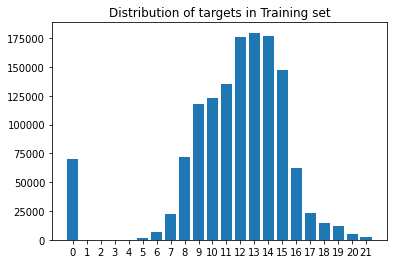

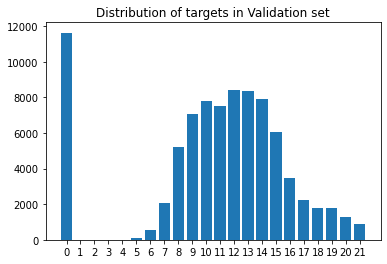

In [13]:
# Show distribution of targets in training and validation set

labels, counts = np.unique(y_train, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Training set')
_ = plt.show()


labels, counts = np.unique(y_val, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Validation set')
_ = plt.show()

In [14]:
if  0:   
    x_train_new = x_train + coords_train
    x_test_new = x_test + coords_test
    x_val_new = x_val + coords_val

In [15]:
# Populate the param 

# import sys,importlib
#importlib.reload(sys.modules['model_hyper_param_log'])
if 1:
    
    base_path =  r'../../../Python_Env/final_layers_rowblock15_21/filtered_image/'
    log ={}
    log['Notebook_name'] = ipynbname.name()
    log['Uniqueness_of_each_run'] = 'March18th: 100% model does not do well on unseen data: adding class weight,augmentation, CONV layer and increasing RNN layers'
    log['base_dir'] = base_path
    log['Train_shape'] = x_train.shape
    log['Output_shape'] = ''
    log['num_epochs'] = ''
    log['batch_size'] = ''
    log['activation_function'] = ''
    log['optimizer'] = ''
    log['learning_rate'] = ''
    log['loss_finction'] = ''
    log['accuracy'] = []
    log['loss'] = []
    log['stop_time'] = ''
    log['Model_config'] = ''
    log['Performance_on_test_set'] = ''
    log['output_path'] = ''  # output: where the trained model is saved
    log['shuffle'] = shuffle
    log['run_completion_comment'] = '' # Comment on training and probably evaluation too
    log['extras'] = [{'standardize':standardize}]


from model_hyper_param_log import create_log_entry, update_log_entry
if "log_idx" in globals():
    log["S_N"] = log_idx
log_idx = create_log_entry('../testing_sheet2.xlsx', log)

Could not get file name: auto-generating name
Activation_function not in workspace
loss_function not in workspace
Accuracy_per_epoch not in workspace
Loss_per_epoch not in workspace
Stop_time not in workspace
Current run hyper_params are dict_keys(['S_N', 'Start_time', 'NoteBook_name', 'Uniqueness_of_each_run', 'Base_dir', 'Train_shape', 'Output_shape', 'num_epochs', 'Activation_function', 'optimizer', 'learning_rate', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop_time', 'Model_config', 'Performance_on_test_set', 'output_path', 'shuffle', 'Computer_name', 'extras']):dict_values([74, '05_April_22_1110', 'LSTM1_Repeat_Augment_Reduce', 'March18th: 100% model does not do well on unseen data: adding class weight,augmentation, CONV layer and increasing RNN layers', '../../../Python_Env/final_layers_rowblock15_21/filtered_image/', (1349017, 9, 21), '', '', '', '', '', '', '', '', '', '', '', '', 1, 'AQ-98JH673', [{'standardize': False}]])
Fields to be updated include: ['Activ

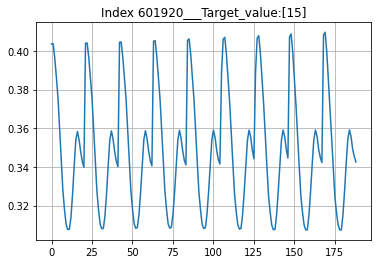

In [16]:
# Visualize some of the input
rand_idx = random.choice( range(1,x_train.shape[0]) )
_ = plt.plot(x_train[rand_idx].flatten())
_ = plt.title(f'Index {rand_idx}___Target_value:{y_train[rand_idx]}' )
_ = plt.grid(which='both')

In [17]:
use_class_weight = True

if use_class_weight:
    each_class,each_count = np.unique(y_train, return_counts = True)
    class_weights = .01 * np.sqrt( len(y_train) / (len(each_class) * each_count) )
    cl_weight_dict = dict(zip(each_class,class_weights))
    

In [18]:
data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(1 / 255.0),        
        layers.RandomCrop(x_train.shape[1], x_train.shape[2],1),
        layers.RandomFlip("vertical"),
    ],
    name="data_augmentation",
)

In [19]:
config['batch_size'] = batch_size= 256
AUTO = tf.data.AUTOTUNE
BUFFER = config['batch_size'] * 4

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_1hot))
train_ds = train_ds.batch(batch_size).cache().prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val_1hot))
val_ds = val_ds.batch(batch_size).cache().prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test_1hot))
test_ds = test_ds.batch(batch_size).cache().prefetch(AUTO)

In [21]:
# Custom ResNet + LSTM model

input_shape = (x_train.shape[1:]) + (1,) #input_shape = (21,5,) #x_train.shape[2]

def ResNetBlock(x,dropout):
    x =   layers.Conv2D(filters=64, kernel_size=5, padding="same")(x) #input_layer
    conv1 = layers.Conv2D(filters=64, kernel_size=5, padding="same")(x) # input_layer, Conv1D
    conv1 = layers.Dropout(dropout)(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = layers.Dropout(dropout)(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.Dropout(dropout)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.Dropout(dropout)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv3 = layers.add([x,conv3])
    conv3 = layers.BatchNormalization()(conv3)
    x = layers.ReLU()(conv3) # Overwrite x
    
    return x


def build_model(
    input_shape,
    head_size,  
    mlp_units,
    r_dropout,
    mlp_dropout,
):
    inputs = tf.keras.Input(shape=input_shape) 
    
    #aug_inputs = data_augmentation(inputs)    
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same")(inputs)
    for _ in range(5):
        x = ResNetBlock(x,r_dropout)
    x = layers.LayerNormalization()(x)
    x = tf.reduce_sum(x,axis=-1)   
    
    x = layers.LSTM(head_size,recurrent_dropout= r_dropout, return_sequences=True)(x) #input_shape=(x.shape[1:]),
    x = layers.LSTM(head_size,recurrent_dropout= r_dropout, return_sequences=True)(x)
    x = layers.LSTM(head_size,recurrent_dropout= r_dropout, return_sequences=True)(x)
    #x = layers.LSTM(head_size,recurrent_dropout= r_dropout, return_sequences=True)(x)
    x = layers.LSTM(head_size,recurrent_dropout= r_dropout)(x)
    x = layers.LayerNormalization()(x)
       
    #for dim in mlp_units:  x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dense(mlp_units, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(config['num_classes'], activation="softmax")(x)
    return tf.keras.Model(inputs, outputs,name ="RowBlockLSTM"+time_stamp)

# Default hyper-param
config['num_epochs'] = 500
config['learning_rate'] = 1e-3
config['head_size'] = 256 
config['mlp_units']= 512  
config['mlp_dropout']= 0.5     
config['dropout']= 0.5         
config['r_dropout'] = 0.5

# Checkpoint path
config['base_path2'] = os.path.abspath(r'Y:\ibikunle\Python_Project\Fall_2021\all_block_data\PulsedTrainTest').replace(os.sep,'/')

model = build_model(input_shape,head_size = config['head_size'],mlp_units=config['mlp_units'], mlp_dropout= config['mlp_dropout'], r_dropout=config['r_dropout'])
#model.summary()

# Update log['extras']
log['extras'][0].update(wandb.config)

# Callbacks
config['start_time'] = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
logz= f"{config['base_path2']}/{ipynbname.name()}/{config['start_time']}_logs/"
callbacks = [
    ModelCheckpoint(f"{config['base_path2']}//{ipynbname.name()}//RowBlockLSTM_ReRun_Checkpoint{time_stamp}.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, min_lr=0.00008, verbose=1),
    EarlyStopping(monitor="val_loss", patience=30, verbose=1), 
    TensorBoard(log_dir = logz,histogram_freq = 1,profile_batch = '1,70', embeddings_freq=50),
    WandbCallback()
]


# Poly Rate scheduler
starter_learning_rate = 0.1
end_learning_rate = 0.0001
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.25)
opt1 = tf.keras.optimizers.RMSprop(learning_rate=config['learning_rate']) #,rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop"
opt2 = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'],amsgrad=False, clipnorm = 1)
opt3 = tf.keras.optimizers.SGD(learning_rate=config['learning_rate'], momentum=0.99, nesterov=True, name="SGD")
poly_rate = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)

top_K = 3
config['start_time'] = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M') # Re-evaluate just before training
print(f'Training start time:{config["start_time"]}')

# model.compile( optimizer = opt, loss= 'categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")])  #label_smoothing=0.05, tf.keras.losses.KLDivergence()
#model.compile( optimizer=opt1,loss="sparse_categorical_crossentropy" , metrics=["sparse_categorical_accuracy"],) #"sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)

model.compile( optimizer=opt2,loss="categorical_crossentropy"  , 
              metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")], ) #tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2) "sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)


history = model.fit(train_ds,
          epochs= config['num_epochs'], 
          batch_size= config['batch_size'], 
          #validation_split = 0.3,
          validation_data=val_ds,
         callbacks=callbacks, class_weight = cl_weight_dict ) #mcp_save, callbacks=[reduce_lr_loss] class_weight = cl_weight_dict

#model = tf.keras.models.load_model(f"{base_path2}//{ipynbname.name()}//RowBlockLSTM_ReRun_Checkpoint{time_stamp}.h5")

config['end_time'] = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M') 
print(f'Training end time:{config["end_time"]}')

# Update manual log file
params_to_be_updated = update_log_entry('../testing_sheet2.xlsx', log_idx, model, history)

Training start time:06_April_22_0029
Epoch 1/500
5270/5270 [==============================] - 2152s 407ms/step - loss: 0.0093 - accuracy: 0.5769 - top-3-accuracy: 0.9013 - val_loss: 1.5746 - val_accuracy: 0.4867 - val_top-3-accuracy: 0.8106
Epoch 2/500
5270/5270 [==============================] - 2129s 404ms/step - loss: 0.0078 - accuracy: 0.6236 - top-3-accuracy: 0.9289 - val_loss: 1.4070 - val_accuracy: 0.5580 - val_top-3-accuracy: 0.8534
Epoch 3/500
5270/5270 [==============================] - 2135s 405ms/step - loss: 0.0068 - accuracy: 0.6632 - top-3-accuracy: 0.9433 - val_loss: 1.3970 - val_accuracy: 0.5852 - val_top-3-accuracy: 0.8614
Epoch 4/500
5270/5270 [==============================] - 2122s 403ms/step - loss: 0.0059 - accuracy: 0.7044 - top-3-accuracy: 0.9551 - val_loss: 1.4042 - val_accuracy: 0.6072 - val_top-3-accuracy: 0.8695
Epoch 5/500
5270/5270 [==============================] - 2124s 403ms/step - loss: 0.0053 - accuracy: 0.7335 - top-3-accuracy: 0.9622 - val_loss: 1.

In [ ]:
logz = logz.replace(os.sep,'/')
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir={logz} --port=8006

In [ ]:
log['Uniqueness_of_each_run'] = 'Using Old data from its source'
run_completion_comment = f'First time training LSTM Test data on FilteredFiltered Old data: 66%'
if "log_idx" in globals():
    log["S_N"] = log_idx
    log['extras'][0]['run_completion_comment'] = run_completion_comment #'Accuracy_per_epoch'
    log['Accuracy_per_epoch'] = f"{history.history['accuracy'][-1]:.4f}"
    log_idx = create_log_entry('../testing_sheet2.xlsx', log)

In [ ]:
# Train further
train_further = False

if train_further:
    history = model.fit(x_train, y_train_1hot,
          epochs= 200,          
          validation_split= 0.3,
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]

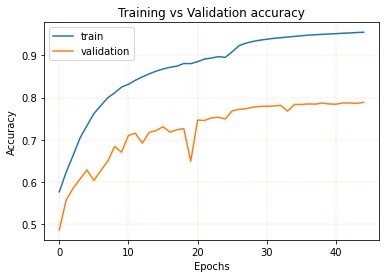

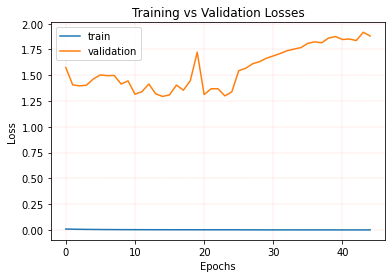

In [22]:
def PlotCurves(model_history):
    plt.plot(model_history.history['accuracy'],label = 'train')
    plt.grid(color = 'r', linestyle = '--', linewidth = .1)    
    #plt.figure()
    plt.plot(model_history.history['val_accuracy'],label = 'validation')
   
    plt.ylabel('Accuracy');
    plt.xlabel('Epochs');
    
    plt.title('Training vs Validation accuracy');
    plt.legend()
    
    plt.figure()
    
    plt.plot(model_history.history['loss'],label = 'train')
    plt.grid(color = 'r', linestyle = '--', linewidth = .1)    
    plt.plot(model_history.history['val_loss'],label = 'validation')
   
    plt.ylabel('Loss');
    plt.xlabel('Epochs');
    
    plt.title('Training vs Validation Losses');
    plt.legend()
    return None

PlotCurves(history)

In [24]:
# Convert labels to categorical orthonormal vectors
y_val_1hot = tf.keras.utils.to_categorical(y_val, config['num_classes'])

_, accuracy,top3_acc = model.evaluate(x_val, y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")
print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")

_,new_col_length,new_row_length = x_train.shape 
#model.save(f'..//all_block_data//PulsedTrainTest//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top3Acc{top3_acc:.3f}_{new_row_length}x{new_col_length}.h5') # Last percentage is 46.85, New:52.4

2635/2635 [==============================] - 166s 63ms/step - loss: 1.8803 - accuracy: 0.7889 - top-3-accuracy: 0.8946
Test accuracy: 78.89%
Test top 5 accuracy: 89.46%
Test_time: 07_April_22_0857


In [ ]:
# Convert labels to categorical orthonormal vectors
y_test_1hot = tf.keras.utils.to_categorical(y_test, config['num_classes'])

_, accuracy,top3_acc = model.evaluate(x_test, y_test_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")
print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'..//all_block_data//PulsedTrainTest//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top3Acc{top3_acc:.3f}_{new_row_length}x{new_col_length}.h5')

In [ ]:
# Look at the distribution ot test and validation data

# Show distribution of targets in training and validation set

labels, counts = np.unique(y_train, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Training set')
_ = plt.show()

labels, counts = np.unique(y_test, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Test set')
_ = plt.show()


labels, counts = np.unique(y_val, return_counts=True)
_ = plt.bar(labels, counts, align='center')
_ = plt.gca().set_xticks(labels)
_ = plt.title('Distribution of targets in Validation set')
_ = plt.show()

In [ ]:
# Dictionary for saving the result of testing all trained model to disk
exp_file_loc = r'../experiment_performance.xlsx'

df = pd.read_excel(exp_file_loc,header = 0, index_col= [0])

In [10]:
# Test different models in the past
#l_model_path = r"Y:\\ibikunle\\Python_Project\\Fall_2021\\all_block_data\\FindPeaks_data\Dec_Train_block_len_21_030122_0614\\NewAttention_RowBlockLSTM1\\10_January_22_1959_Acc_0.743_Top3Acc0.898_21x9.h5"
# This (commented above) was less than 20% for both test and validation
base = r'Y:\\ibikunle\\Python_Project\\Fall_2021'
paths = [ #r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_NewData-Class_weights\14_February_22_1859_Acc_0.644_Top3Acc0.851_21x9.h5",
    #r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_NewData-Class_weights\01_February_22_0912_Acc_0.651_Top3Acc0.838_21x9.h5",
    #r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_Augment_Reduce\10_February_22_1201_Acc_0.638_Top3Acc0.830_21x9.h5",
    #r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_Augment_Reduce\03_February_22_1826_Acc_0.628_Top3Acc0.846_21x9.h5",
    #r"\all_block_data\PulsedTrainTest\NewAttention_RowBlock_Feb2022\best_model.h5",
    #r"\all_block_data\Filteredfiltered_data\LSTM1_RepeatExactly\27_January_22_2325_RowBlockLSTM_checkpoint.h5",
    #r"\all_block_data\FindPeaks_data\Dec_Train_block_len_21_030122_0614\NewAttention_RowBlockLSTM1\10_January_22_1959_Acc_0.743_Top3Acc0.898_21x9.h5",
    #r"\Model_and_weights\LSTM1_Repeat_NewData\28_January_22_1949_Acc_0.665_Top3Acc0.833_21x9.h5",
    #r"\Model_and_weights\LSTM1_Repeat_NewData-Class_weights\RowBlockLSTM_ReRun_Checkpoint01_February_22_0912.h5",
    #r"\Model_and_weights\LSTM1_Repeat_NewData-Class_weights\RowBlockLSTM_ReRun_Checkpoint14_February_22_1859.h5",
    #r"\Model_and_weights\NewAttention_RowBlockLSTM2_TrainData\CheckpointRowBlockLSTM_dropout.h5",
    #r"\Model_and_weights\NewAttention_RowBlockLSTM3_PulsedFindPeaks\RowBlockLSTM_checkpoint_26_January_22_1620.h5",
    #r"\Model_and_weights\NewAttention_RowBlockLSTM3_PulsedFindPeaks\RowBlockLSTM_checkpoint_25_January_22_0934.h5" 
    #r"\all_block_data\\NewAttention_RowBlockLSTM1\\11_January_22_16512_Acc_0.781_Top3Acc0.939_21x9.h5",
    #r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_NewData-Class_weights\14_February_22_1859_Acc_0.696_Top3Acc0.887_21x9.h5",
    #r"\all_block_data\\PulsedTrainTest\LSTM1_Repeat_NewData-Class_weights-Augment\02_February_22_1529_Acc_0.630_Top3Acc0.842_21x9.h5",
    #r"\all_block_data\\PulsedTrainTest\LSTM1_Repeat_NewData-Class_weights-Augment\02_February_22_1529_Test_Acc_0.673_Top3Acc0.885_21x9.h5",
    #r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_NewData-Class_weights-Augment\RowBlockLSTM_ReRun_Checkpoint02_February_22_1529.h5",
    r"\all_block_data\PulsedTrainTest\LSTM1_Repeat_Augment_Reduce\25_February_22_0934_Acc_0.815_Top3Acc0.898_21x9.h5"
]
    
    
for path_idx in range(len(paths)):
    
    perf_dict = {}

    l_model_path = base + paths[path_idx]
    l_model = tf.keras.models.load_model(l_model_path)

    perf_dict['path'] = l_model_path
    perf_dict['short_path'] = os.path.basename(l_model_path)

    y_val_1hot = tf.keras.utils.to_categorical(y_val, num_classes)
    _, accuracy,top3_acc = l_model.evaluate(x_val, y_val_1hot)

    print(f" Model {os.path.basename(l_model_path)} performance ")
    print(f"Val accuracy: {round(accuracy * 100, 2)}%")
    print(f"Val top 5 accuracy: {round(top3_acc * 100, 2)}%")
    print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")

    perf_dict['val_accuracy'] = round(accuracy * 100, 2)
    perf_dict['val_top_K'] = round(top3_acc * 100, 2) 

    y_test_1hot = tf.keras.utils.to_categorical(y_test, num_classes)

    _, accuracy,top3_acc = l_model.evaluate(x_test, y_test_1hot)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")
    print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")

    perf_dict['test_accuracy'] = round(accuracy * 100, 2)
    perf_dict['test_top_K'] = round(top3_acc * 100, 2) 

    df = df.append(perf_dict, ignore_index=True)
    df.to_excel(exp_file_loc,index=False)


2789/2789 [==============================] - 275s 98ms/step - loss: 1.5584 - accuracy: 0.8147 - top-3-accuracy: 0.8976
 Model 25_February_22_0934_Acc_0.815_Top3Acc0.898_21x9.h5 performance 
Val accuracy: 81.47%
Val top 5 accuracy: 89.76%
Test_time: 03_March_22_1214
8365/8365 [==============================] - 829s 99ms/step - loss: 1.3708 - accuracy: 0.8839 - top-3-accuracy: 0.9518
Test accuracy: 88.39%
Test top 5 accuracy: 95.18%
Test_time: 03_March_22_1227


In [ ]:
# Check some predictions

import random
check_start = random.randint(0,len(x_val))

print(f'Check start {check_start}')
[(int(y_val[idx]), np.argmax(model.predict(np.expand_dims(x_val[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]



In [28]:
# Test model manually on all val data
def predict_using_model(model,model_path=None,x_val = x_val, y_val=y_val):    
    y_pred = [ np.argmax(model.predict(np.expand_dims(x_val[idx],axis=0))) for idx in range(len(x_val))  ] #range(len(x_val))

    #combined_result = zip(y_val,y_pred)

    val_exact_accuracy = 100 * sum([1 if y_pred[idx]==y_val[idx]   else 0 for idx in range(len(y_pred)) ]) / len(y_pred)
    val_margin3_accuracy = 100 * sum([1 if abs(y_pred[idx]-y_val[idx]) < 3 else 0 for idx in range(len(y_pred)) ]) / len(y_pred)
    
    if model_path is not None:
        print(f' Predicting model is {os.path.relpath(model_path)} ')        
    print(f' Exact accuracy is {val_exact_accuracy: .5f} %')
    print(f' Top 5% accuracy is {val_margin3_accuracy: .5f} %')
    
    return y_pred



In [29]:
y_pred = predict_using_model(model,x_val = x_test, y_val=y_test)

 Exact accuracy is  86.80000 %
 Top 5% accuracy is  90.70018 %


In [33]:
base = r'Y:\\ibikunle\\Python_Project\\Fall_2021'
paths = [ r"\all_block_data\\NewAttention_RowBlockLSTM1\\11_January_22_16512_Acc_0.781_Top3Acc0.939_21x9.h5",
         r"\\all_block_data\PulsedTrainTest\LSTM1_Repeat_Augment_Reduce\RowBlockLSTM_ReRun_Checkpoint09_March_22_1205.h5" ]
y_preds = []
for path_idx in range(len(paths)):      
    l_model_path = base + paths[path_idx]
    l_model = tf.keras.models.load_model(l_model_path)
    y_preds.append( predict_using_model(l_model,l_model_path) )

 Predicting model is ..\all_block_data\NewAttention_RowBlockLSTM1\11_January_22_16512_Acc_0.781_Top3Acc0.939_21x9.h5 
 Exact accuracy is  58.22863 %
 Top 5% accuracy is  72.19202 %
 Predicting model is ..\all_block_data\PulsedTrainTest\LSTM1_Repeat_Augment_Reduce\RowBlockLSTM_ReRun_Checkpoint09_March_22_1205.h5 
 Exact accuracy is  81.46807 %
 Top 5% accuracy is  85.14778 %


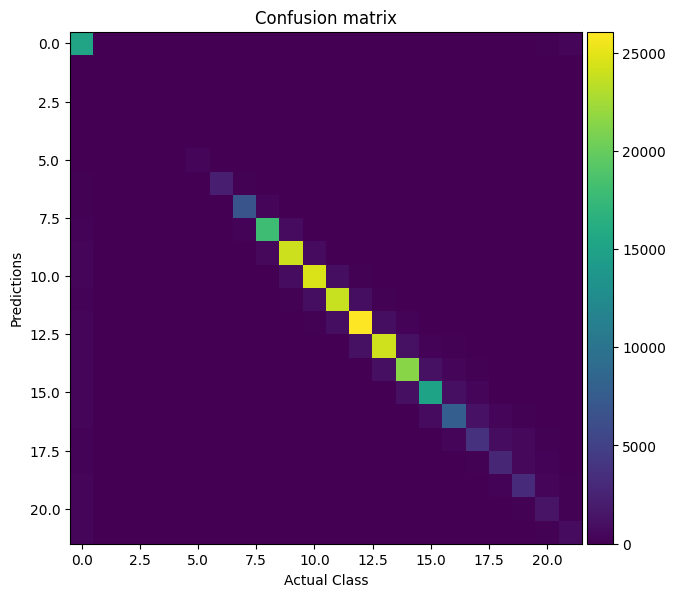

In [31]:
# Confusion Matrix and ROC/AUC

def create_plot_confusion_matrix(y_pred, num_classes,y_val=y_val):
    model_predictions = np.asarray(y_pred)
    ground_truth = y_val.squeeze()

    # Prediction per Ground-truth class
    class_predictions = [ model_predictions[ground_truth==idx]  for idx in range(num_classes) ]

    # Confusion matrix
    confusion_mtx = np.zeros((num_classes,num_classes) )

    for pred,actual in zip(y_pred,y_val): # Rows=Prediction, Columns = Actual
        confusion_mtx[pred,actual] +=1
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, ax = plt.subplots(figsize=(7,15),dpi = 100);
    shw=ax.imshow(confusion_mtx)
    #bar= plt.colorbar(shw)

    _=plt.ylabel('Predictions')
    _=plt.xlabel('Actual Class')
    _=plt.title('Confusion matrix')

    # ax.set_xticklabels(list(range(num_classes)))
    # ax.set_yticklabels(list(range(num_classes)))

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    #bar.set_label('ColorBar')
    _ = plt.colorbar(shw, cax=cax)
    
    return class_predictions
    
model1_class_predictions = create_plot_confusion_matrix(y_pred,config['num_classes'],y_val=y_test)

#model2_class_predictions = create_plot_confusion_matrix(y_preds[1],config['num_classes'])
    

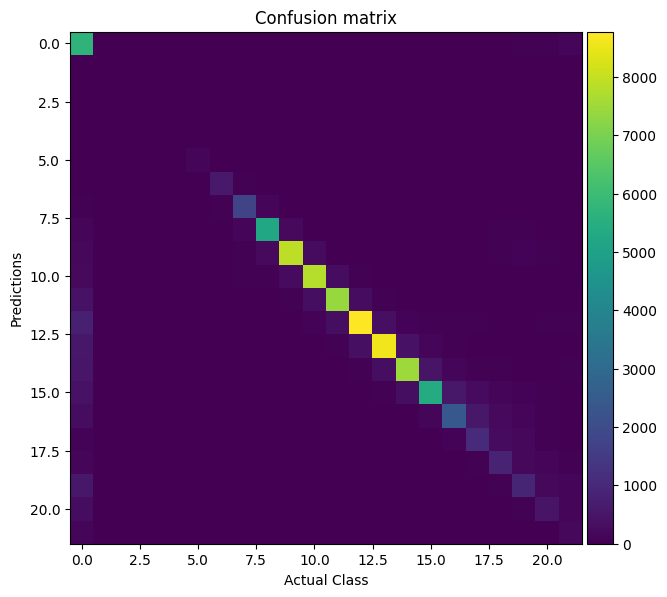

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(7,15),dpi = 100);
shw=ax.imshow(confusion_mtx)
#bar= plt.colorbar(shw)

_=plt.ylabel('Predictions')
_=plt.xlabel('Actual Class')
_=plt.title('Confusion matrix')

# ax.set_xticklabels(list(range(num_classes)))
# ax.set_yticklabels(list(range(num_classes)))

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#bar.set_label('ColorBar')
_ = plt.colorbar(shw, cax=cax)

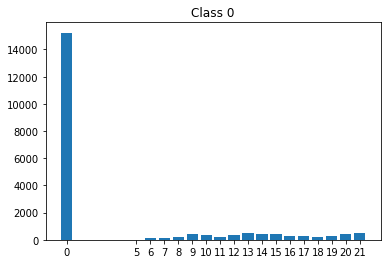

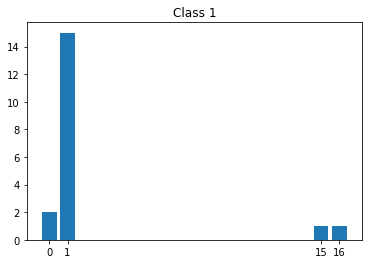

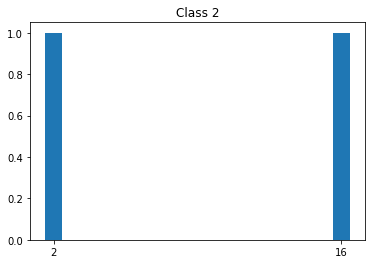

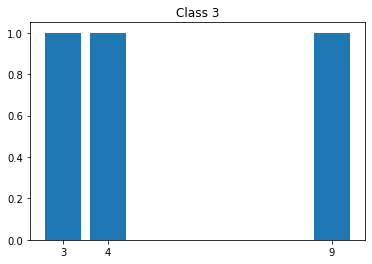

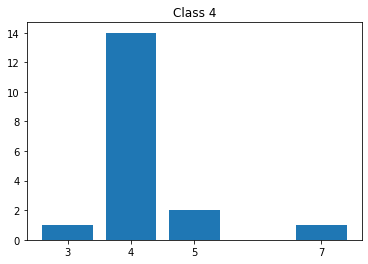

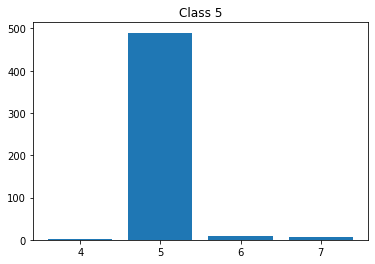

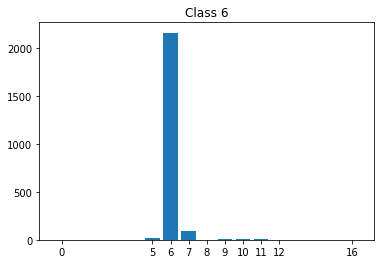

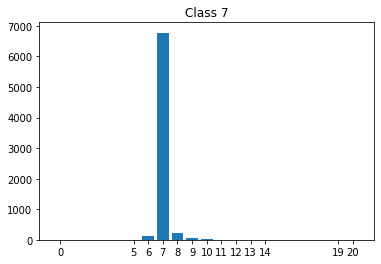

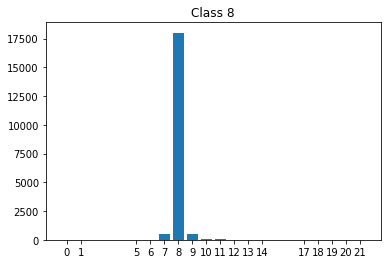

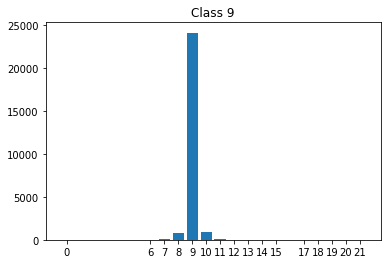

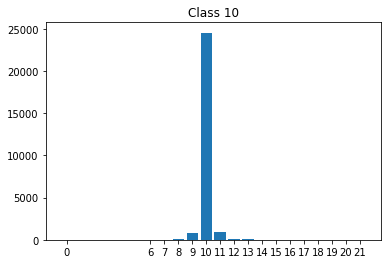

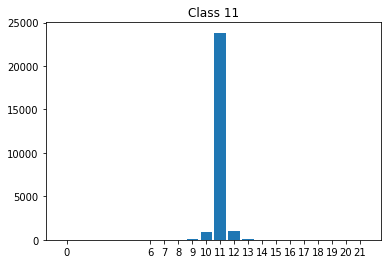

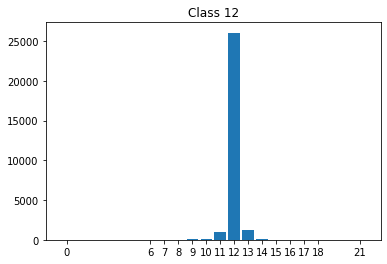

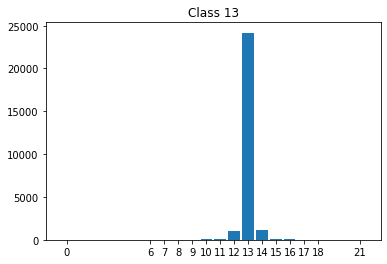

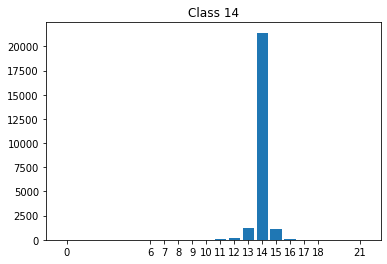

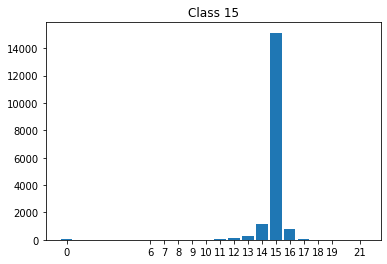

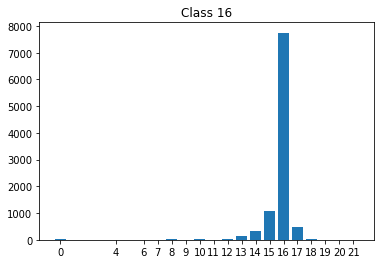

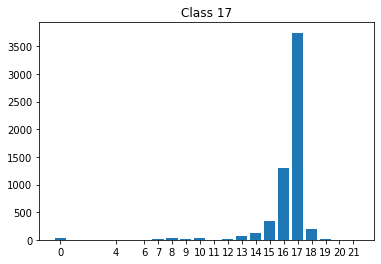

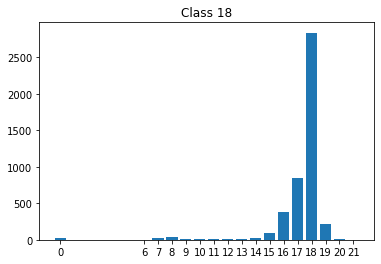

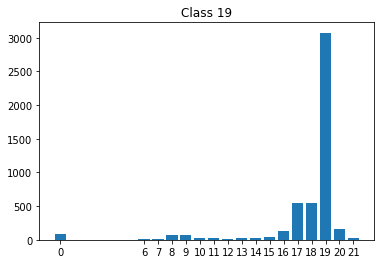

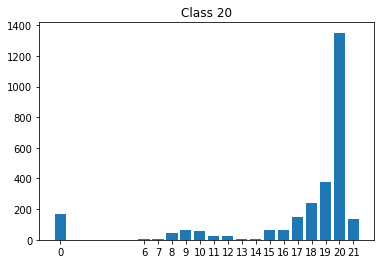

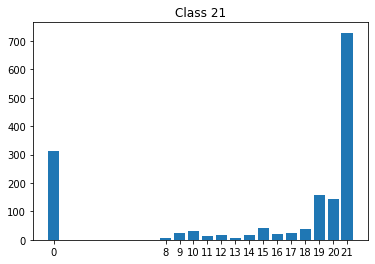

In [32]:
def hist_class_predictions(class_predictions):    
    # Histogram of each class prediction
    for idx,each_class in enumerate(class_predictions):
        _ = plt.figure()
        _ = plt.title('Class %s'%idx)
        labels, counts = np.unique(each_class, return_counts=True)
        _ = plt.bar(labels, counts, align='center')
        _ = plt.gca().set_xticks(labels)
        _ = plt.show()
        
hist_class_predictions(model1_class_predictions)

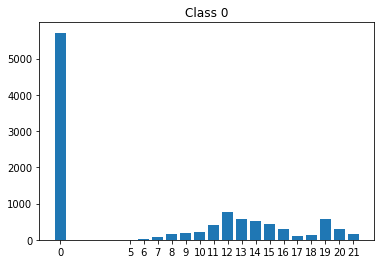

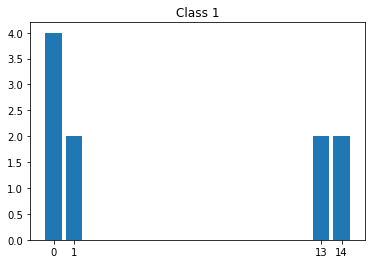

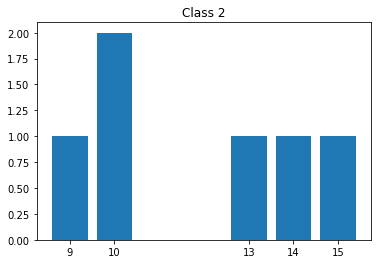

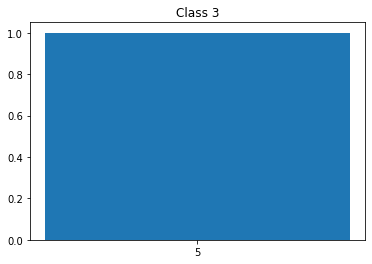

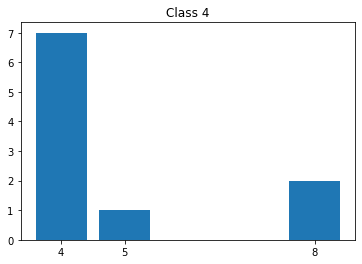

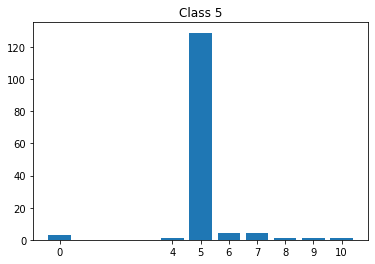

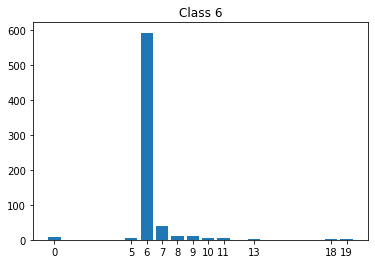

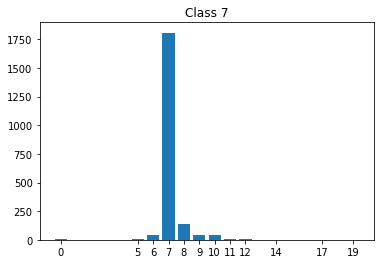

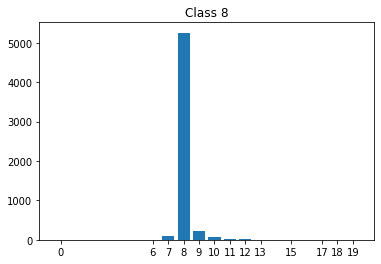

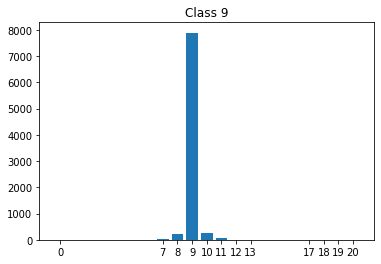

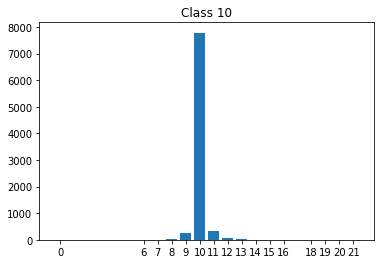

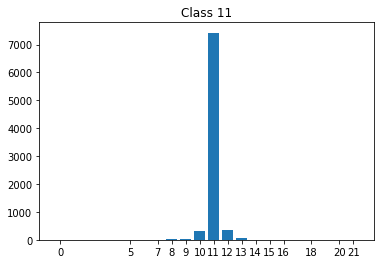

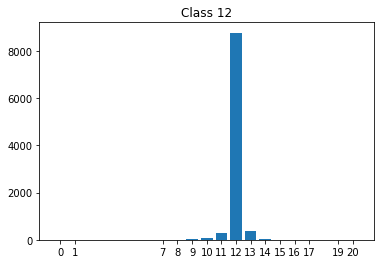

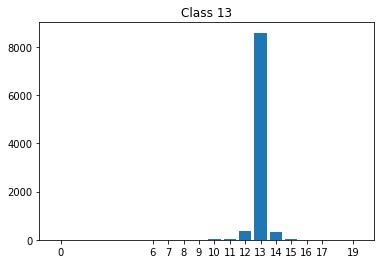

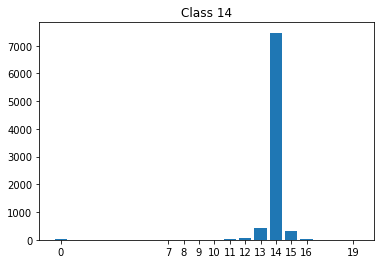

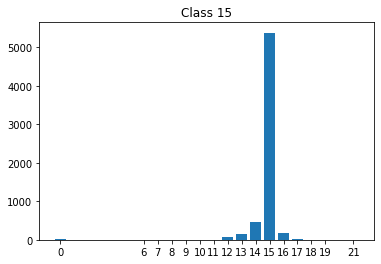

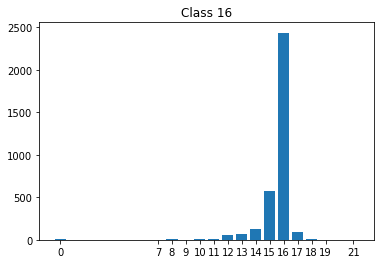

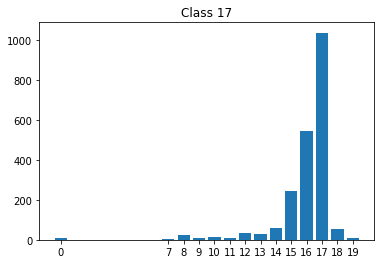

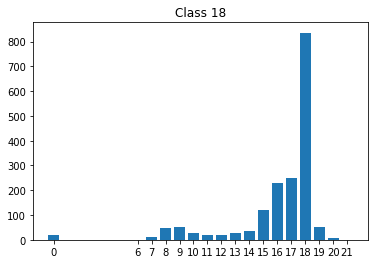

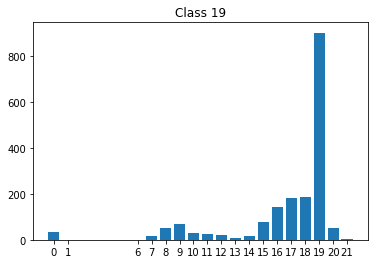

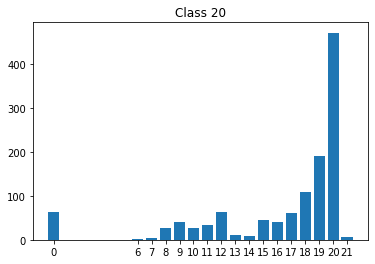

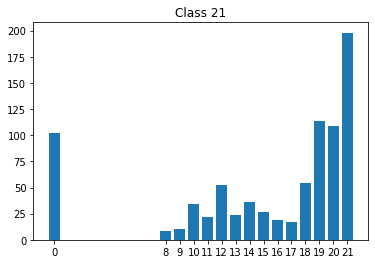

In [38]:
hist_class_predictions(model2_class_predictions)

In [25]:
# Check model on unseen data
test_cnt = [ (orig_all_idx==elem).sum() for elem in test_echo_idx]
test_coords = []
for elem in test_cnt:
    test_coords.append([*range(elem)])
test_coords = np.concatenate(test_coords).ravel()

# Get all idx of echos in train_echo_idx
val_search_idx = np.where(orig_all_idx == test_echo_idx) #np.where( np.in1d(all_idx,train_echo_idx) )
val_search_idx = list(val_search_idx[0])

test_data = orig_all_data[val_search_idx]
test_target = orig_all_target[val_search_idx]
test_idx = orig_all_idx[val_search_idx]

In [26]:
# Reshape and prepare data

test_data = np.reshape( test_data, (test_data.shape[0],max_class,-1),order ='F' )
test_data = test_data[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
test_data = np.transpose(test_data,(0,2,1))
test_target[test_target == max_class+1 ] = 0


In [27]:
# Convert labels to categorical orthonormal vectors
test_target_1hot = tf.keras.utils.to_categorical(test_target, config['num_classes'])

time_stamp = datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')
_, accuracy,top3_acc = model.evaluate(test_data, test_target_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top3_acc * 100, 2)}%")
print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")


12306/12306 [==============================] - 956s 78ms/step - loss: 2.8054 - accuracy: 0.5870 - top-3-accuracy: 0.9170
Test accuracy: 58.7%
Test top 5 accuracy: 91.7%
Test_time: 25_March_22_2133


In [ ]:
# Reshape and prepare data

test_data = np.reshape( test_data, (test_data.shape[0],max_class,-1),order ='F' )
test_data = test_data[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
test_data = np.transpose(test_data,(0,2,1))
test_target[test_target == max_class+1 ] = 0

# Predict on unseen data using given models
y_preds = []
for path_idx in range(len(paths)):      
    l_model_path = base + paths[path_idx]
    l_model = tf.keras.models.load_model(l_model_path)
    y_preds.append( predict_using_model(l_model,l_model_path, x_val = test_data, y_val = test_target) )

In [ ]:
# Check some predictions

import random
check_start = random.randint(0,len(x_val))

print(f'Check start {check_start}')
[(int(y_val[idx]), np.argmax(model.predict(np.expand_dims(x_val[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]



In [ ]:
# Train further (last training 12/8/2021 was for 30 epochs - 150 epochs(w/o reshape order) previously overfitted
# Also, the train set was not reshuffled, but train further uses shuffled train data (Stopped the train further after 30 epocks- acc 14% poor. Retraining from scratch )

# New - train further: Got almost 100% acc but val acc was ~88%. Trying to push that higher

start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')

print(f'Restart Training start time:{start_time}')
#batch_size = 64
history2 = l_model.fit(x_train, y_train_1hot,
          epochs= 150, 
          batch_size= 128, 
          validation_data=(x_test, y_test_1hot),callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]callbacks=callbacks

Restart Training start time:09_March_22_1209
Epoch 1/150
11153/11153 [==============================] - 2118s 190ms/step - loss: 1.0873 - accuracy: 0.9959 - top-3-accuracy: 1.0000 - val_loss: 1.3710 - val_accuracy: 0.8836 - val_top-3-accuracy: 0.9520
Epoch 2/150
11153/11153 [==============================] - 2216s 199ms/step - loss: 1.0872 - accuracy: 0.9959 - top-3-accuracy: 1.0000 - val_loss: 1.3708 - val_accuracy: 0.8840 - val_top-3-accuracy: 0.9518
Epoch 3/150
11153/11153 [==============================] - 2089s 187ms/step - loss: 1.0872 - accuracy: 0.9960 - top-3-accuracy: 1.0000 - val_loss: 1.3709 - val_accuracy: 0.8838 - val_top-3-accuracy: 0.9518
Epoch 4/150
11153/11153 [==============================] - 2145s 192ms/step - loss: 1.0872 - accuracy: 0.9960 - top-3-accuracy: 1.0000 - val_loss: 1.3705 - val_accuracy: 0.8839 - val_top-3-accuracy: 0.9519
Epoch 5/150
11153/11153 [==============================] - 2152s 193ms/step - loss: 1.0872 - accuracy: 0.9959 - top-3-accuracy: 1.0

In [ ]:
PlotCurves(history2)

In [ ]:
_, accuracy,top_3_accuracy = model.evaluate(x_val, y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_3_accuracy * 100, 2)}%")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_top3{top_3_accuracy:.3f}_{new_row_length}x{new_col_length}.h5')

In [ ]:
# Try prediction on difficult data

if truncate_data:    

    x_difficult = raw_data1['echo_cnn_input'][stop_idx+1:]
    y_difficult = raw_data1['echo_cnn_target'][stop_idx+1:]

    x_difficult = np.reshape( x_difficult, (x_difficult.shape[0],max_class,-1) )
    x_difficult = x_difficult[:,:,mid_pt-neigh:mid_pt+neigh+1]
    # x_train = np.reshape(x_train,(x_train.shape[0],-1))
    x_difficult = np.transpose(x_difficult,(0,2,1))

    # y_difficult[y_difficult == num_classes] = 0
    # y_difficult = tf.keras.utils.to_categorical(y_difficult, num_classes)


In [ ]:
(x_difficult.shape,y_difficult.shape)

In [ ]:
# Check some predictions

difficult_start = random.randint(0,len(x_val)) #3500 #

print(f'Check start {difficult_start}')
[(int(y_difficult[idx]), np.argmax(model.predict(np.expand_dims(x_difficult[idx],axis=0))) ) for idx in range(difficult_start,difficult_start+50) ]



In [ ]:
# Attempt loading past model (after crash) and start training again
load_model = 0
if load_model:
    model2 = tf.keras.models.load_model(r'Y:\ibikunle\Python_Project\Fall_2021\all_block_data\Old_data\Dec_Train_block_len_21_131121_2213\NewAttention_RowBlockLSTM1\22_November_21_0929_Acc_0.669_Top3Acc0.8506_21x9.h5'
                                    ,)

In [ ]:
# Train further
batch_size = 64
history2 = model.fit(x_train, y_train_1hot,
          epochs= 30, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test_1hot),callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]callbacks=callbacks

In [ ]:
# Convert labels to categorical orthonormal vectors
y_val_1hot = tf.keras.utils.to_categorical(y_val, num_classes)

_, accuracy,top3_acc = model.evaluate(x_val, y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

_,new_col_length,new_row_length = x_train.shape 
model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top3Acc{top3_acc:.3f}_{new_row_length}x{new_col_length}.h5')

In [ ]:
# Test model on val data

y_diff_pred = [ np.argmax(model.predict(np.expand_dims(x_difficult[idx],axis=0))) for idx in range(3000,3050) ] #len(x_difficult)

difficult_exact_accuracy = 100 * sum([1 if y_diff_pred[idx]==y_difficult[idx]   else 0 for idx in range(len(y_diff_pred)) ]) / len(y_diff_pred)
difficult_margin5_accuracy = 100 * sum([1 if abs(y_diff_pred[idx]-y_difficult[idx]) < 3 else 0 for idx in range(len(y_diff_pred)) ]) / len(y_diff_pred)

print(f' Exact accuracy is {difficult_exact_accuracy: .5f} %')
print(f' Top 5% accuracy is {difficult_margin5_accuracy: .5f} %')



In [ ]:
len(y_diff_pred)